In [2]:
# common imports
from pathlib import Path
import os
import numpy as np
import pandas as pd
import seaborn as sns
# sci-kit learn is our one-stop shop for machine learning!
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
# read in the dataset
filepath = Path.joinpath(Path.cwd().parent, 'data', 'Video_Games_Sales_as_at_22_Dec_2016.csv')
games = pd.read_csv(filepath)

In [4]:
# data set info
games.shape

(16719, 16)

In [4]:
# what is the data look like
games.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# check null data
games.isnull().sum().sort_values(ascending=False).head(10)

User_Count         9129
Critic_Score       8582
Critic_Count       8582
Rating             6769
User_Score         6704
Developer          6623
Year_of_Release     269
Publisher            54
Name                  2
Genre                 2
dtype: int64

# many missing data. Do the following the clean up the data
1. Drop columns that are unrelevant to this analysis ('Developer', 'User_Count', 'Critic_Count'
2. Fill in 'Unknown' for 'Rating' and 'Publisher'
3. Make datatype consistent for modeling

In [12]:
# 1. drop columns
games.drop(['Developer'] ,inplace =True, axis =1)
games.drop(['Critic_Count'] ,inplace =True, axis =1)
games.drop(['User_Count'] ,inplace =True, axis =1)

In [13]:
# 2. fill default value
games['Rating'] = games['Rating'].fillna("Unknown")
games['Publisher'] = games['Publisher'].fillna("Unknown")

In [14]:
# 3. check column datatype
games.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object

While Critic_Score is float64, User_Score is an object. Need to convert, but first need to clean up what's in User_Score so the conversion can be successful. 

Scores are critical in the data analysis and any default value will skew the data, so for any row missing score data, we'll have to dorp it

In [9]:
games['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [7]:
# top 100 sale games
games.sort_values(by=['Global_Sales'], ascending=False)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,RP
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,RP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16294,Simple 2000 Series Vol. 120: The Saigo no Nipp...,PS2,2007.0,Strategy,D3Publisher,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,RP
16295,Casper,GBA,2002.0,Adventure,Microids,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,RP
16296,AKB1/48: Idol to Guam de Koishitara...,X360,NaN,Misc,NaN,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,RP
16297,Adventure Time: The Secret of the Nameless,X360,2014.0,Adventure,Little Orbit,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,RP


<AxesSubplot:>

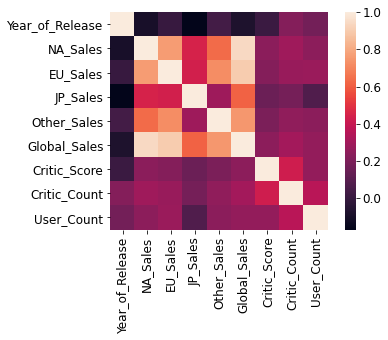

In [8]:
# check correlations, sales columns have strong correlation. We can use Global Sales the target
sns.heatmap(games.corr(), vmax=1, square=True)

In [9]:
# check again
games.isnull().sum().sort_values(ascending=False).head()

User_Count      9129
Critic_Score    8582
Critic_Count    8582
User_Score      6704
Developer       6623
dtype: int64

In [10]:
# the project is to determine reveiw score vs sales, data missing score is not very useful. 
# create a new dataset for data with score, while the orignal one for sales trend analysis
games_with_score = games.copy()
games_with_score.dropna(inplace=True)

In [11]:
# new data set info
games_with_score.shape

(6889, 16)

In [12]:
# check column data type
games_with_score.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

In [13]:
# User score is not numeric type, change it and scale it to the samem scale with Critic_Score
#Chagne data type:
games_with_score['User_Score'] = games_with_score['User_Score'].astype('float64')

In [14]:
# set user score the same scale with critic score
games_with_score["User_Score"] = games_with_score["User_Score"].apply(lambda x: x*10)

In [41]:
features = ['Year_of_Release','Critic_Score','Critic_Count','User_Score', 'User_Count']
target = ['Global_Sales']

In [42]:
# split data into feature and sale. Many sales column (by region), that we can target separetly
y = games_with_score[target].copy()
#X = games_with_score.drop(["Name","Year_of_Release","Platform", "Genre", "Publisher","Developer","Rating","NA_Sales","EU_Sales","JP_Sales","Other_Sales", "Global_Sales"], axis=1)
X = games_with_score[features].copy()

In [43]:
# Now, split both X and y data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=0.2, 
                                       random_state=42)

In [44]:
X_train.head()

,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count
1515,2015.0,78.0,22.0,61.0,402.0
10929,2004.0,78.0,28.0,85.0,15.0
7486,2002.0,33.0,6.0,75.0,18.0
11191,2008.0,71.0,22.0,66.0,8.0
12683,2006.0,78.0,36.0,78.0,8.0


In [45]:
y_train.head()

,Global_Sales
1515,1.30
10929,0.09
7486,0.21
11191,0.09
12683,0.06


In [46]:
# Create a local instance of the sklearn class
lin_reg = LinearRegression()

In [47]:
# Fit your instance to the training dataset
lin_reg.fit(X_train, y_train)

LinearRegression()

In [48]:
lin_score_train = lin_reg.score(X_test, y_test)
lin_score_test = lin_reg.score (X_train, y_train)

In [49]:
print("Training score: ",lin_score_train)
print("Testing score: ",lin_score_test)

Training score:  0.2184161633152566
Testing score:  0.11730272627982308


In [50]:
# Make predictions on the testing dataset
y_preds = lin_reg.predict(X_test)

In [51]:
# Print the coefficients.
print(lin_reg.intercept_)
print(lin_reg.coef_)

[74.07693886]
[[-0.0372824   0.01923401  0.02083646 -0.00715384  0.0005408 ]]


In [52]:
# Evaluation. What do these mean?
print('mae', mean_absolute_error(y_test, y_preds))
print('rmse', np.sqrt(mean_squared_error(y_test, y_preds)))
print('R2', r2_score(y_test, y_preds))

mae 0.7118998716215021
rmse 1.4575594436692545
R2 0.2184161633152566


In [53]:
# try KNN
from sklearn import neighbors
n_neighbors=5
knn_reg=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

In [54]:
knn_score_train = knn_reg.score(X_test, y_test)
knn_score_test = knn_reg.score(X_train, y_train)

print("Training score: ",knn_score_train)
print("Testing score: ",knn_score_test)

Training score:  -0.14196842784206964
Testing score:  0.28138851757040884


In [55]:
# Make predictions on the testing dataset
y_preds = knn_reg.predict(X_test)

In [56]:
# Evaluation. What do these mean?
print('mae', mean_absolute_error(y_test, y_preds))
print('rmse', np.sqrt(mean_squared_error(y_test, y_preds)))
print('R2', r2_score(y_test, y_preds))

mae 0.7504179970972424
rmse 1.7618362419351654
R2 -0.14196842784206964
